## Setup

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

%cd /content
%ls -l -h

/content
total 22G
-rw-r--r--    1 root root 122M Apr  3 20:41 data.csv
-rw-r--r--    1 root root 1.7M Mar 29 19:01 Dataset_3_20_2024.csv
-rw-r--r--    1 root root  21G Apr 14 16:30 Dataset.zip
drwxr-xr-x    2 root root 4.0K Apr  9 21:10 disk2/
drwxr-xr-x    4 root root 4.0K Apr 15 02:09 eric_cache/
-rw-r--r--    1 root root  49M Mar 29 19:35 labeled_data.csv
-rw-r--r--    1 root root 1.7M Mar 27 20:11 labels.csv
drwxr-xr-x    4 root root 4.0K Apr 23 01:44 model_1_a.model/
-rw-r--r--    1 root root  114 Apr 19 19:49 model_history1.pkl
-rw-r--r--    1 root root   96 Apr 19 18:37 model_history.pkl
-rw-r--r--    1 root root  114 Apr 20 20:56 model_resnext_history2.pkl
-rw-r--r--    1 root root  168 Apr 20 22:02 model_resnext_history3.pkl
-rw-r--r--    1 root root  114 Apr 20 20:17 model_resnext_history.pkl
drwxr-xr-x 1465 root root  36K Mar 16 23:00 PPMI_test/
drwxr-xr-x    1 root root 4.0K Feb  5 20:33 sample_data/
drwxr-xr-x    3 root root 4.0K Apr 22 15:59 shree_cache/
drwxr-xr-x   12 

In [2]:
%ls disk2 -l -h -r

total 0


In [3]:
# check disk usage
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         193G  188G  5.5G  98% /
tmpfs            64M     0   64M   0% /dev
shm             5.5G     0  5.5G   0% /dev/shm
/dev/sda1       193G  188G  5.5G  98% /opt/bin
tmpfs            15G   56K   15G   1% /var/colab


In [4]:
# see where is demanding most storage
!du -h /content | sort -rh | head -n 10

100G	/content
64G	/content/PPMI_test
15G	/content/silvia_cache
3.1G	/content/silvia_cache/model_parnet_more_epochs.model/variables
3.1G	/content/silvia_cache/model_parnet_more_epochs.model
3.1G	/content/silvia_cache/model_parnet.model/variables
3.1G	/content/silvia_cache/model_parnet.model
3.1G	/content/silvia_cache/model_parnet_7epochs.model/variables
3.1G	/content/silvia_cache/model_parnet_7epochs.model
1.8G	/content/silvia_cache/model_resnet50.model/variables


In [5]:
#!pip install pydicom

In [6]:
from PIL import Image
import dask.dataframe as dd
import os
import pydicom as dicom

from tensorflow import keras

from keras import Sequential
from keras.layers import Dense, Flatten, Conv3D, Conv2D, MaxPooling3D
from keras.utils import to_categorical

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import sys

## GPU Information

In [7]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)
  #For GPU tunning

Fri Apr 26 21:32:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [8]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')
  #FOR ram tunning

Your runtime has 31.6 gigabytes of available RAM

You are using a high-RAM runtime!


## Data processing

In [ ]:
label_df = pd.read_csv('Dataset_3_20_2024.csv')
label_df['Subject'] = label_df['Subject'].astype(str)

# Create a dictionary where the key is the Subject and the value is the Group
group_mapping = label_df.set_index('Subject')['Group'].to_dict()

label_df

,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
0,I495208,92834,Prodromal,M,66,BL,MRI,MPRAGE GRAPPA2,Original,3/20/2015,DCM,NaN
1,I495209,92834,Prodromal,M,66,BL,MRI,Axial T2 TSE with Fat Sat,Original,3/20/2015,DCM,NaN
2,I440709,91837,Prodromal,M,74,BL,MRI,AX DUAL_TSE,Original,3/04/2014,DCM,NaN
3,I440711,91837,Prodromal,M,74,BL,MRI,Cor FLAIR TI_2800ms,Original,3/04/2014,DCM,NaN
4,I440710,91837,Prodromal,M,74,BL,MRI,SAG 3D T1,Original,3/04/2014,DCM,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
17437,I1473172,100001,PD,M,67,BL,MRI,SAG 3D MPRAGE,Original,10/07/2020,DCM,NaN
17438,I1473183,100001,PD,M,67,BL,MRI,AX T2 GRE MT,Original,10/07/2020,DCM,NaN
17439,I1658557,100001,PD,M,70,V06,MRI,AX T2 GRE MT,Original,11/29/2022,DCM,NaN
17440,I1658550,100001,PD,M,70,V06,MRI,AX T2 GRE MT,Original,11/29/2022,DCM,NaN


In [ ]:
### get all image files and their attributes

DATA_DIR = '/content/disk2/PPMI'

file_data = []
for subj_id in os.listdir(DATA_DIR):
  for imaging_method in os.listdir(os.path.join(DATA_DIR, subj_id)):
    for date in os.listdir(os.path.join(DATA_DIR, subj_id, imaging_method)):
      for im_id in os.listdir(os.path.join(DATA_DIR, subj_id, imaging_method, date)):
        for image_name in os.listdir(os.path.join(DATA_DIR, subj_id, imaging_method, date, im_id)):
          absolute_path = os.path.join(DATA_DIR, subj_id, imaging_method, date, im_id, image_name)
          file_data.append({
              'Subject': subj_id,
              'imaging_method': imaging_method,
              'date_str': date,
              'Image Data ID': im_id,
              'file_name': image_name,
              'full_path': absolute_path
          })
fileinfo_df = pd.DataFrame(file_data)

# map the Group values to fileinfo_df
fileinfo_df['Group'] = fileinfo_df['Subject'].map(group_mapping)

# map Group to labels
fileinfo_df['label'] = fileinfo_df['Group'].map(lambda s: {'PD': 0, 'Prodromal': 1, 'Control': 2}.get(s, -1))

fileinfo_df

,Subject,imaging_method,date_str,Image Data ID,file_name,full_path,Group,label
0,3770,Axial_PD-T2_TSE,2012-02-08_10_16_11.0,I322876,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...,/content/disk2/PPMI/3770/Axial_PD-T2_TSE/2012-...,PD,0
1,3770,Axial_PD-T2_TSE,2012-02-08_10_16_11.0,I322876,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...,/content/disk2/PPMI/3770/Axial_PD-T2_TSE/2012-...,PD,0
2,3770,Axial_PD-T2_TSE,2012-02-08_10_16_11.0,I322876,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...,/content/disk2/PPMI/3770/Axial_PD-T2_TSE/2012-...,PD,0
3,3770,Axial_PD-T2_TSE,2012-02-08_10_16_11.0,I322876,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...,/content/disk2/PPMI/3770/Axial_PD-T2_TSE/2012-...,PD,0
4,3770,Axial_PD-T2_TSE,2012-02-08_10_16_11.0,I322876,PPMI_3770_MR_Axial_PD-T2_TSE__br_raw_201208091...,/content/disk2/PPMI/3770/Axial_PD-T2_TSE/2012-...,PD,0
...,...,...,...,...,...,...,...,...
403167,4112,ax_flair,2013-03-10_09_37_52.0,I366364,PPMI_4112_MR_ax_flair_br_raw_20130410132828973...,/content/disk2/PPMI/4112/ax_flair/2013-03-10_0...,PD,0
403168,4112,ax_flair,2013-03-10_09_37_52.0,I366364,PPMI_4112_MR_ax_flair_br_raw_20130410132830986...,/content/disk2/PPMI/4112/ax_flair/2013-03-10_0...,PD,0
403169,4112,ax_flair,2013-03-10_09_37_52.0,I366364,PPMI_4112_MR_ax_flair_br_raw_20130410132844503...,/content/disk2/PPMI/4112/ax_flair/2013-03-10_0...,PD,0
403170,4112,ax_flair,2013-03-10_09_37_52.0,I366364,PPMI_4112_MR_ax_flair_br_raw_20130410132844862...,/content/disk2/PPMI/4112/ax_flair/2013-03-10_0...,PD,0


In [ ]:
### statistics
for col in fileinfo_df:
  print(col, fileinfo_df[col].unique().size)

print()
print(fileinfo_df['label'].value_counts())

print()
print(fileinfo_df['imaging_method'].value_counts())

Subject 1463
imaging_method 214
date_str 1873
Image Data ID 2238
file_name 455026
full_path 455026
Group 4
label 4

 1    229880
 0    195993
 2     28224
-1       929
Name: label, dtype: int64

R_L_RESTING_STATE_FMRI_ep2d_fid_basic_bold    153600
rsfMRI_RL                                      38712
Resting_State_fMRI_R_L                         21120
MPRAGE_GRAPPA                                  20416
DTI_LR                                         13233
                                               ...  
DTI_RL_ColFA                                       1
Coronal                                            1
Transverse                                         1
DTI_LR_TENSOR_B0                                   1
DTI_RL_TRACEW                                      1
Name: imaging_method, Length: 214, dtype: int64


In [ ]:
### image scan types
# Sagittal, Coronal, and Axial parts of the brain

scantype_indicators = {
    'sagittal': 'sag',
    'axial': 'ax',
    'coronal': 'cor',
}
scantype_counts = {scantype: 0 for scantype in scantype_indicators.keys()}
scantype_counts['unknown'] = 0

for desc in fileinfo_df['imaging_method']:
  types_assigned = 0

  # check established types
  for scantype, indicator in scantype_indicators.items():
    if indicator in desc.lower():
      scantype_counts[scantype] += 1
      types_assigned += 1

  # if nothing assigned, assign unknown
  if types_assigned == 0:
    scantype_counts['unknown'] += 1
  # if multiple assigned, print to debug
  if types_assigned >= 2:
    print(desc)

scantype_counts

{'sagittal': 33304, 'axial': 23764, 'coronal': 617, 'unknown': 397341}

In [ ]:
### filter data down to MPRAGE_GRAPPA images
#data_df = fileinfo_df[fileinfo_df['imaging_method'].apply(lambda s: 'ax' in s.lower())]
data_df = fileinfo_df[fileinfo_df['imaging_method'] == 'MPRAGE_GRAPPA']
display(data_df)

### statistics
for col in data_df:
  print(col, data_df[col].unique().size)

print()
print(data_df['label'].value_counts())

print()
print(data_df['imaging_method'].value_counts())

,Subject,imaging_method,date_str,Image Data ID,file_name,full_path,Group,label
48,3770,MPRAGE_GRAPPA,2014-02-19_07_53_30.0,I420360,PPMI_3770_MR_MPRAGE_GRAPPA__br_raw_20140416154...,/content/disk2/PPMI/3770/MPRAGE_GRAPPA/2014-02...,PD,0
49,3770,MPRAGE_GRAPPA,2014-02-19_07_53_30.0,I420360,PPMI_3770_MR_MPRAGE_GRAPPA__br_raw_20140416154...,/content/disk2/PPMI/3770/MPRAGE_GRAPPA/2014-02...,PD,0
50,3770,MPRAGE_GRAPPA,2014-02-19_07_53_30.0,I420360,PPMI_3770_MR_MPRAGE_GRAPPA__br_raw_20140416154...,/content/disk2/PPMI/3770/MPRAGE_GRAPPA/2014-02...,PD,0
51,3770,MPRAGE_GRAPPA,2014-02-19_07_53_30.0,I420360,PPMI_3770_MR_MPRAGE_GRAPPA__br_raw_20140416154...,/content/disk2/PPMI/3770/MPRAGE_GRAPPA/2014-02...,PD,0
52,3770,MPRAGE_GRAPPA,2014-02-19_07_53_30.0,I420360,PPMI_3770_MR_MPRAGE_GRAPPA__br_raw_20140416154...,/content/disk2/PPMI/3770/MPRAGE_GRAPPA/2014-02...,PD,0
...,...,...,...,...,...,...,...,...
452810,3591,MPRAGE_GRAPPA,2017-03-13_09_13_33.0,I864627,PPMI_3591_MR_MPRAGE_GRAPPA__br_raw_20170627144...,/content/disk2/PPMI/3591/MPRAGE_GRAPPA/2017-03...,PD,0
452811,3591,MPRAGE_GRAPPA,2017-03-13_09_13_33.0,I864627,PPMI_3591_MR_MPRAGE_GRAPPA__br_raw_20170627144...,/content/disk2/PPMI/3591/MPRAGE_GRAPPA/2017-03...,PD,0
452812,3591,MPRAGE_GRAPPA,2017-03-13_09_13_33.0,I864627,PPMI_3591_MR_MPRAGE_GRAPPA__br_raw_20170627144...,/content/disk2/PPMI/3591/MPRAGE_GRAPPA/2017-03...,PD,0
452813,3591,MPRAGE_GRAPPA,2017-03-13_09_13_33.0,I864627,PPMI_3591_MR_MPRAGE_GRAPPA__br_raw_20170627144...,/content/disk2/PPMI/3591/MPRAGE_GRAPPA/2017-03...,PD,0


Subject 109
imaging_method 1
date_str 115
Image Data ID 116
file_name 20416
full_path 20416
Group 3
label 3

0    12128
2     4416
1     3872
Name: label, dtype: int64

MPRAGE_GRAPPA    20416
Name: imaging_method, dtype: int64


Image shape: (256, 256)


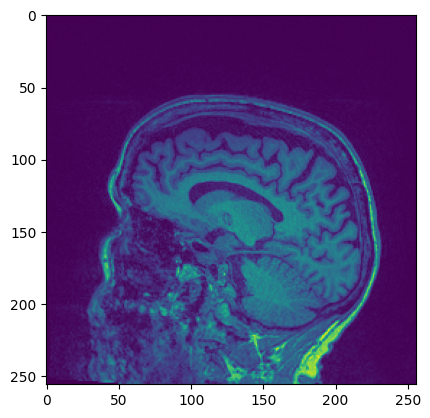

In [ ]:
### preview sample image
pixels = dicom.dcmread(data_df['full_path'].iloc[8000]).pixel_array
print('Image shape:', pixels.shape)
plt.imshow(pixels);

In [ ]:
### validate shapes of all samples
sample_shapes = {}
for i, full_path in enumerate(data_df['full_path']):
  pixels = dicom.dcmread(full_path).pixel_array
  sample_shape = pixels.shape

  if sample_shape not in sample_shapes:
    sample_shapes[sample_shape] = 1
  else:
    sample_shapes[sample_shape] += 1

  if i % 5000 == 0:
    print(f"Image {i} processed")

sample_shapes

Image 0 processed
Image 5000 processed
Image 10000 processed
Image 15000 processed
Image 20000 processed


{(256, 240): 15648, (256, 256): 4768}

## Model Input

In [ ]:
def path_to_pixels(full_path):
  """load image from path, expected to be either (256, 256), or (256, 240), in which case pad to (256, 256)"""
  # load pixels
  ds = dicom.dcmread(full_path).pixel_array
  assert (ds.shape == (256, 256)) or (ds.shape == (256, 240))

  # reshape to (256, 256)
  pad_cols = int((256 - ds.shape[1]) / 2)
  assert (pad_cols == 0) or (pad_cols == 8)
  ds_padded = np.pad(ds, ((0, 0), (pad_cols, pad_cols)), 'constant')
  assert ds_padded.shape == (256, 256)

  return ds_padded

In [ ]:
### get X (pixels) and y

X = []
y = []
for label, full_path in zip(data_df['label'], data_df['full_path']):
  X.append(path_to_pixels(full_path))
  y.append(label)

X = np.array(X)
y = np.array(y)

In [ ]:
# one hot encode
from keras.utils import to_categorical
y_onehot = to_categorical(y)

In [ ]:
#np.save('/content/eric_cache/X.npy', X)
#np.save('/content/eric_cache/y.npy', y)

In [9]:
#X = np.load('/content/eric_cache/X.npy')
#y = np.load('/content/eric_cache/y.npy')

# use Silvia's cache instead since mine got deleted
X = np.load('/content/silvia_cache/X.npy')
y = np.load('/content/silvia_cache/y.npy')

In [10]:
display(X.shape)
display(y.shape)

(20416, 256, 256)

(20416,)

In [11]:
# train validation test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=17)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=17)
del X
del y
y_train_onehot, y_val_onehot, y_test_onehot = to_categorical(y_train), to_categorical(y_val), to_categorical(y_test)

display(X_train.shape)
display(y_train.shape)
display(y_train_onehot.shape)
display(X_val.shape)
display(y_val.shape)
display(y_val_onehot.shape)
display(X_test.shape)
display(y_test.shape)
display(y_test_onehot.shape)

(12249, 256, 256)

(12249,)

(12249, 3)

(4083, 256, 256)

(4083,)

(4083, 3)

(4084, 256, 256)

(4084,)

(4084, 3)

## Training/Testing Model_2

v2 is trained with 5 epochs

v3 uses a validation set and tunes epochs

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, AveragePooling2D, add, Activation, BatchNormalization
from tensorflow.keras.models import Model

# Define the ResNet identity block with a parameter to adjust the shortcut path
def resnet_identity_block(input_tensor, kernel_size, filters, is_first_block_of_first_layer=False):
    filters1, filters2 = filters

    x = Conv2D(filters1, (1, 1), padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters1, (kernel_size, kernel_size), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, (1, 1), padding='same')(x)
    x = BatchNormalization()(x)

    if is_first_block_of_first_layer:
        # Add a 1x1 Conv to the shortcut path to match the dimension change
        shortcut = Conv2D(filters2, (1, 1), padding='same')(input_tensor)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut = input_tensor

    x = add([x, shortcut])
    x = Activation('relu')(x)
    return x

# Define the input shape and input layer
input_shape = (256, 256, 1)
input_layer = Input(shape=input_shape)

# Build the model using the defined blocks and layers
x = Conv2D(64, (7, 7), activation='relu', padding='same')(input_layer)
x = MaxPooling2D((2, 2), padding='same')(x)

x = resnet_identity_block(x, 3, [64, 64])
x = resnet_identity_block(x, 3, [64, 64])

x = resnet_identity_block(x, 3, [128, 128], is_first_block_of_first_layer=True)
x = resnet_identity_block(x, 3, [128, 128])

x = AveragePooling2D((2, 2), padding='same')(x)

x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(units=256, activation='relu')(x)
x = Dropout(0.5)(x)

output_layer = Dense(units=3, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model (if needed specify the optimizer, loss, and metrics)
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model architecture
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         3200      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         4160      ['max_pooling2d[0][0]']   

In [ ]:
from tensorflow.keras import mixed_precision

# Set the global policy to mixed_float16
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)


# Compile the model again with the new policy
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model.fit(
    X_train,
    y_train_onehot,
    batch_size=1,  # More typical batch size, adjust as necessary
    epochs=4,  # Number of epochs to train
    verbose=1,  # Shows a progress bar during training
)

Epoch 1/4
12249/12249 [==============================] - 1043s 84ms/step - loss: 4.1918 - accuracy: 0.6047
Epoch 2/4
12249/12249 [==============================] - 1028s 84ms/step - loss: 0.5538 - accuracy: 0.7953
Epoch 3/4
12249/12249 [==============================] - 1016s 83ms/step - loss: 0.3137 - accuracy: 0.8987
Epoch 4/4
12249/12249 [==============================] - 1021s 83ms/step - loss: 0.2214 - accuracy: 0.9377


In [ ]:
model.save('/content/silvia_cache/model_parnet.model')

In [ ]:
model.evaluate(
    X_val,
    y_val_onehot,
    batch_size=1,
    verbose=1
)

4083/4083 [==============================] - 43s 10ms/step - loss: 0.6310 - accuracy: 0.8589


[0.6309590339660645, 0.8589272499084473]

In [ ]:
model.evaluate(
    X_test,
    y_test_onehot,
    batch_size=1,
    verbose=1
)

4084/4084 [==============================] - 42s 10ms/step - loss: 0.5861 - accuracy: 0.8729


[0.5861144065856934, 0.8729187250137329]

In [ ]:
from keras.models import load_model

In [ ]:
model = load_model('/content/silvia_cache/model_parnet.model')

In [ ]:
model.fit(
    X_train,
    y_train_onehot,
    batch_size=1,  # More typical batch size, adjust as necessary
    epochs=3,  # Number of epochs to train
    verbose=1,  # Shows a progress bar during training
)

Epoch 1/3
12249/12249 [==============================] - 1037s 84ms/step - loss: 0.2624 - accuracy: 0.9476
Epoch 2/3
12249/12249 [==============================] - 1026s 84ms/step - loss: 0.1621 - accuracy: 0.9621
Epoch 3/3
12249/12249 [==============================] - 1029s 84ms/step - loss: 0.1392 - accuracy: 0.9681


In [ ]:
model.save('/content/silvia_cache/model_parnet_more_epochs.model')

In [ ]:
model.evaluate(
    X_val,
    y_val_onehot,
    batch_size=1,
    verbose=1
)

4083/4083 [==============================] - 46s 11ms/step - loss: 0.6239 - accuracy: 0.8908


[0.6239283084869385, 0.8907666206359863]

In [ ]:
model.evaluate(
    X_test,
    y_test_onehot,
    batch_size=1,
    verbose=1
)

4084/4084 [==============================] - 45s 11ms/step - loss: 0.5765 - accuracy: 0.8989


[0.5764686465263367, 0.8988736271858215]

## Figures

In [ ]:
from tensorflow.keras import mixed_precision

# Set the global policy to mixed_float16
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)


# Compile the model again with the new policy
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model = load_model('/content/silvia_cache/model_parnet.model')

In [ ]:
model.fit(
    X_train,
    y_train_onehot,
    batch_size=1,  # More typical batch size, adjust as necessary
    epochs=3,  # Number of epochs to train
    verbose=1,  # Shows a progress bar during training
)

Epoch 1/3
12249/12249 [==============================] - 1026s 83ms/step - loss: 0.2241 - accuracy: 0.9461
Epoch 2/3
12249/12249 [==============================] - 1019s 83ms/step - loss: 0.1831 - accuracy: 0.9618
Epoch 3/3
12249/12249 [==============================] - 1022s 83ms/step - loss: 0.1577 - accuracy: 0.9684


In [ ]:
model.save('/content/silvia_cache/model_parnet_7epochs.model')

In [ ]:
model.evaluate(
    X_val,
    y_val_onehot,
    batch_size=1,
    verbose=1
)

4083/4083 [==============================] - 43s 10ms/step - loss: 0.4652 - accuracy: 0.8937


[0.4651763141155243, 0.8937056064605713]

In [ ]:
model.evaluate(
    X_test,
    y_test_onehot,
    batch_size=1,
    verbose=1
)

4084/4084 [==============================] - 42s 10ms/step - loss: 0.4511 - accuracy: 0.8989


[0.45109060406684875, 0.8988736271858215]

In [ ]:
history = model.fit(
    X_train,
    y_train_onehot,
    batch_size=1,  # More typical batch size, adjust as necessary
    epochs=3,  # Number of epochs to train
    verbose=1,  # Shows a progress bar during training
)

Epoch 1/3
12249/12249 [==============================] - 1032s 83ms/step - loss: 0.2339 - accuracy: 0.9496
Epoch 2/3
12249/12249 [==============================] - 1016s 83ms/step - loss: 0.1719 - accuracy: 0.9624
Epoch 3/3
12249/12249 [==============================] - 1019s 83ms/step - loss: 0.1351 - accuracy: 0.9665


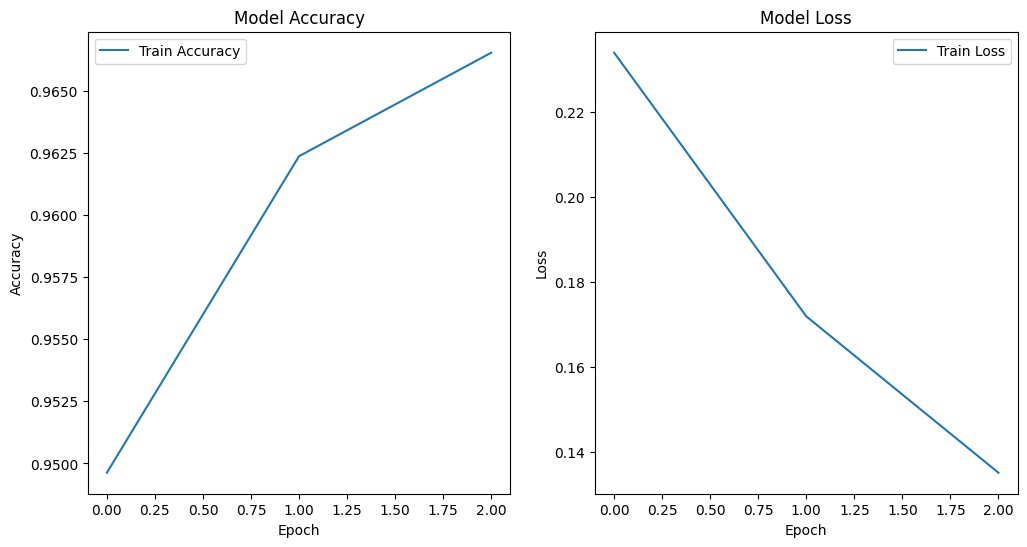

In [ ]:

# Plot training accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
if 'val_accuracy' in history.history:  # Only plot if validation accuracy exists
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot training loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
if 'val_loss' in history.history:  # Only plot if validation loss exists
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()


In [ ]:
import pickle
with open('model_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

In [ ]:
with open('model_history.pkl', 'rb') as file:
    loaded_history = pickle.load(file)

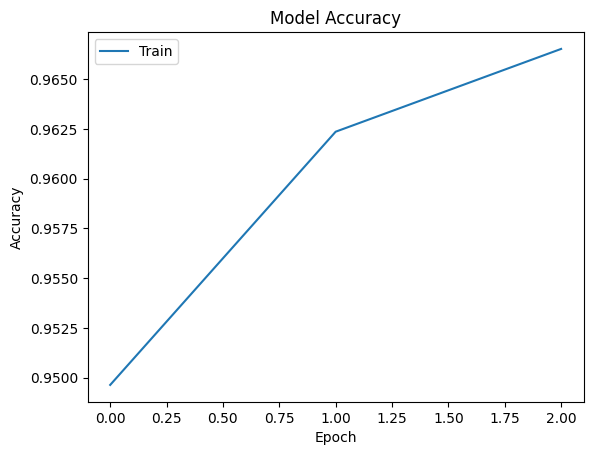

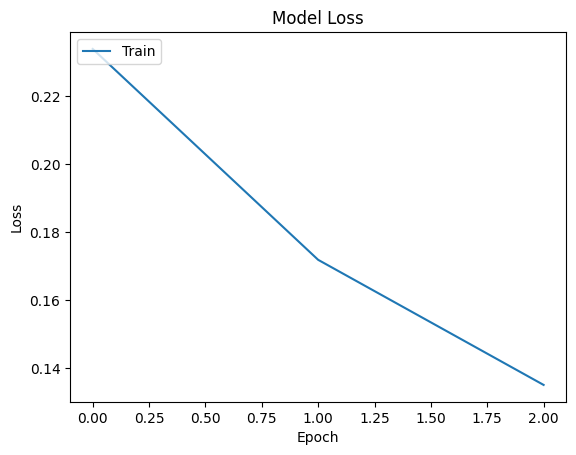

In [ ]:
plt.plot(loaded_history['accuracy'])
if 'val_accuracy' in loaded_history:
    plt.plot(loaded_history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(loaded_history['loss'])
if 'val_loss' in loaded_history:
    plt.plot(loaded_history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
history1 = model.fit(
    X_train,
    y_train_onehot,
    batch_size=1,  # More typical batch size, adjust as necessary
    epochs=4,  # Number of epochs to train
    verbose=1,  # Shows a progress bar during training
)

Epoch 1/4
12249/12249 [==============================] - 1031s 83ms/step - loss: 4.2128 - accuracy: 0.6200
Epoch 2/4
12249/12249 [==============================] - 1027s 84ms/step - loss: 0.4943 - accuracy: 0.8122
Epoch 3/4
12249/12249 [==============================] - 1027s 84ms/step - loss: 0.3181 - accuracy: 0.9030
Epoch 4/4
12249/12249 [==============================] - 1027s 84ms/step - loss: 0.3475 - accuracy: 0.9440


In [ ]:
import pickle
with open('model_history1.pkl', 'wb') as file:
    pickle.dump(history1.history, file)

In [ ]:
import pickle

# Load the first training history
with open('model_history1.pkl', 'rb') as file:
    history1 = pickle.load(file)

# Load the second training history
with open('model_history.pkl', 'rb') as file:
    history2 = pickle.load(file)

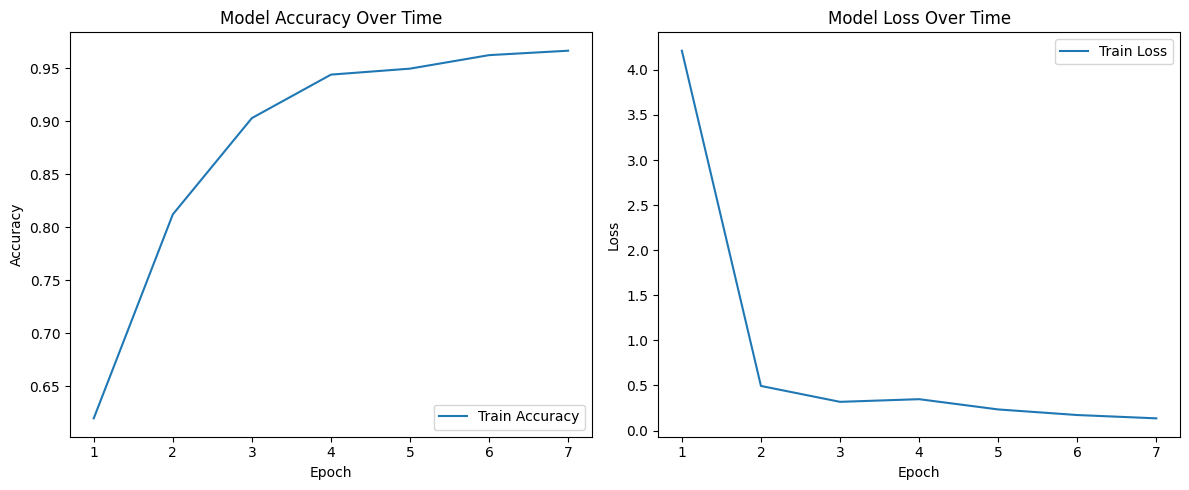

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history1' and 'history2' have been loaded as shown previously

# Concatenate the metrics from both histories
def concat_histories(key):
    return history1[key] + history2[key]  # Combine lists from both training sessions

# Prepare concatenated data
accuracy = concat_histories('accuracy')
val_accuracy = concat_histories('val_accuracy') if 'val_accuracy' in history1 else None
loss = concat_histories('loss')
val_loss = concat_histories('val_loss') if 'val_loss' in history1 else None

# Calculate the epoch numbers for better plotting
epochs = list(range(1, len(accuracy) + 1))

# Plot training and validation accuracy for concatenated histories
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(epochs, accuracy, label='Train Accuracy')
if val_accuracy:
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Model Accuracy Over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training and validation loss for concatenated histories
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(epochs, loss, label='Train Loss')
if val_loss:
    plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Model Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()


128/128 [==============================] - 25s 169ms/step


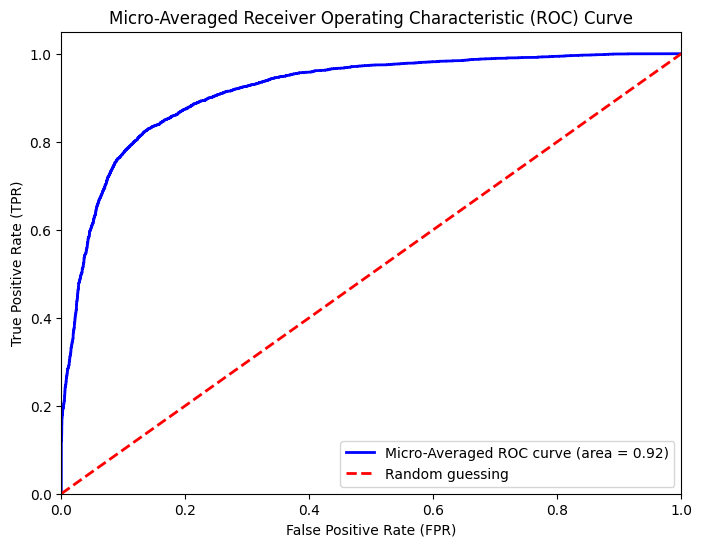

In [ ]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

# Load the model
model = load_model('/content/silvia_cache/model_parnet_7epochs.model')
# Make predictions
y_pred = model.predict(X_test)

# Binarize the labels
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Compute micro-averaged ROC curve and AUC
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_pred.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot micro-averaged ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_micro, tpr_micro, color='blue', lw=2, label='Micro-Averaged ROC curve (area = %0.2f)' % roc_auc_micro)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Micro-Averaged Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


128/128 [==============================] - 19s 149ms/step


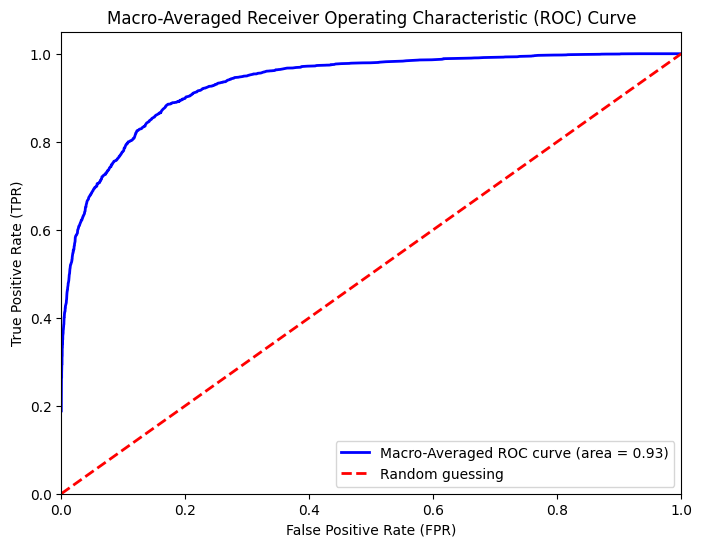

In [ ]:


# Make predictions
y_pred = model.predict(X_test)

# Binarize the labels
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Compute ROC curve and AUC for each class
n_classes = y_test_bin.shape[1]
fpr_macro = dict()
tpr_macro = dict()
roc_auc_macro = dict()
for i in range(n_classes):
    fpr_macro[i], tpr_macro[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc_macro[i] = auc(fpr_macro[i], tpr_macro[i])

# Compute macro-averaged ROC curve and AUC
all_fpr = np.unique(np.concatenate([fpr_macro[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr_macro[i], tpr_macro[i])
mean_tpr /= n_classes
fpr_macro["macro"] = all_fpr
tpr_macro["macro"] = mean_tpr
roc_auc_macro["macro"] = auc(fpr_macro["macro"], tpr_macro["macro"])

# Plot macro-averaged ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_macro["macro"], tpr_macro["macro"], color='blue', lw=2, label='Macro-Averaged ROC curve (area = %0.2f)' % roc_auc_macro["macro"])
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Macro-Averaged Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


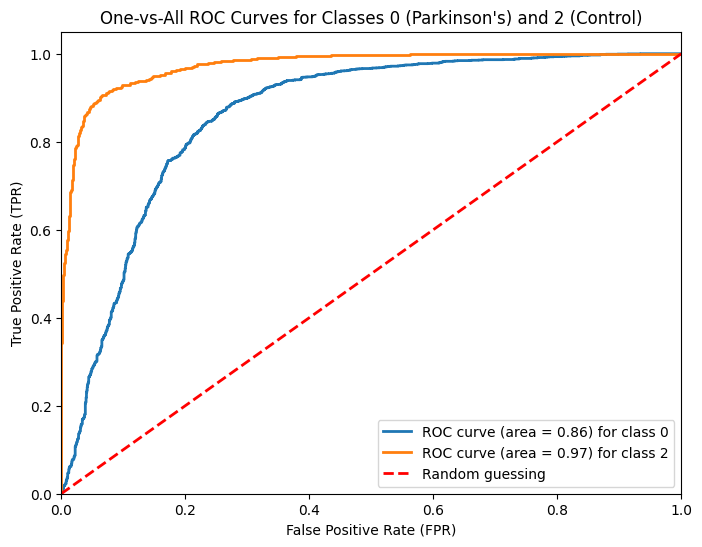

In [ ]:
# Compute One-vs-All ROC curves for classes 0 and 2
fpr_ova_02 = dict()
tpr_ova_02 = dict()
roc_auc_ova_02 = dict()
for i in [0, 2]:  # Considering classes 0 and 2
    fpr_ova_02[i], tpr_ova_02[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc_ova_02[i] = auc(fpr_ova_02[i], tpr_ova_02[i])

# Plot One-vs-All ROC curves for classes 0 and 2
plt.figure(figsize=(8, 6))
for i in [0, 2]:  # Considering classes 0 and 2
    plt.plot(fpr_ova_02[i], tpr_ova_02[i], lw=2, label='ROC curve (area = %0.2f) for class %d' % (roc_auc_ova_02[i], i))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('One-vs-All ROC Curves for Classes 0 (Parkinson\'s) and 2 (Control)')
plt.legend(loc="lower right")
plt.show()


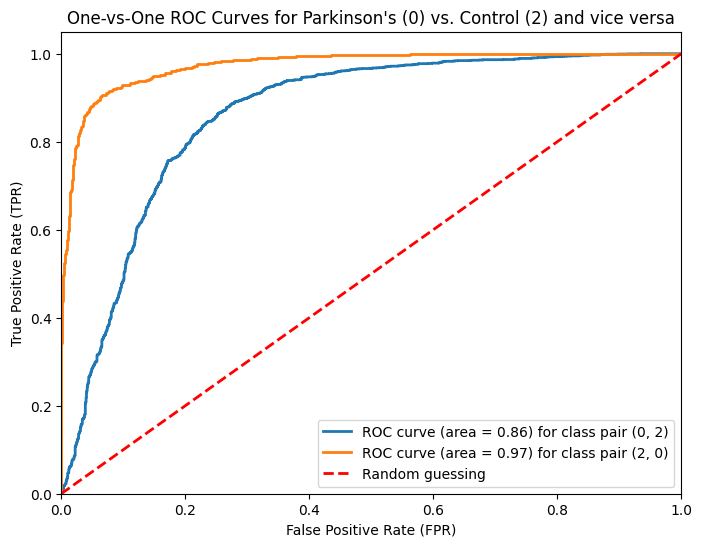

In [ ]:
from itertools import combinations

# Define class combinations of interest (Parkinson's vs. Control)
class_combinations_of_interest = [(0, 2), (2, 0)]  # Parkinson's (0) vs. Control (2) and vice versa

# Compute One-vs-One ROC curves for class combinations of interest
fpr_ovo_of_interest = dict()
tpr_ovo_of_interest = dict()
roc_auc_ovo_of_interest = dict()
for pair in class_combinations_of_interest:
    i, j = pair
    fpr_ovo_of_interest[pair], tpr_ovo_of_interest[pair], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc_ovo_of_interest[pair] = auc(fpr_ovo_of_interest[pair], tpr_ovo_of_interest[pair])

# Plot One-vs-One ROC curves for class combinations of interest
plt.figure(figsize=(8, 6))
for pair in class_combinations_of_interest:
    plt.plot(fpr_ovo_of_interest[pair], tpr_ovo_of_interest[pair], lw=2, label='ROC curve (area = %0.2f) for class pair %s' % (roc_auc_ovo_of_interest[pair], pair))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('One-vs-One ROC Curves for Parkinson\'s (0) vs. Control (2) and vice versa')
plt.legend(loc="lower right")
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

# Make binary predictions based on the probabilities
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate precision, recall, F1 score, and accuracy
precision = precision_score(y_test_bin, y_pred_binary, average='micro')
recall = recall_score(y_test_bin, y_pred_binary, average='micro')
f1 = f1_score(y_test_bin, y_pred_binary, average='micro')
accuracy = accuracy_score(y_test_bin, y_pred_binary)

# Calculate specificity
tn, fp, fn, tp = confusion_matrix(y_test_bin.ravel(), y_pred_binary.ravel()).ravel()
specificity = tn / (tn + fp)

# Print the results
print("Precision:", precision)
print("Recall (Sensitivity):", recall)
print("Specificity:", specificity)
print("F1 Score:", f1)
print("Accuracy:", accuracy)


Precision: 0.9038112522686026
Recall (Sensitivity): 0.36581782566111654
Specificity: 0.9805337904015671
F1 Score: 0.520829701934809
Accuracy: 0.36581782566111654


In [ ]:
model = load_model('/content/silvia_cache/model_parnet_7epochs.model')

Precision for Parkinson's: 0.872852233676976
Precision for Control: 0.8691931540342298
F1 Score for Parkinson's: 0.18642201834862385
F1 Score for Control: 0.851497005988024


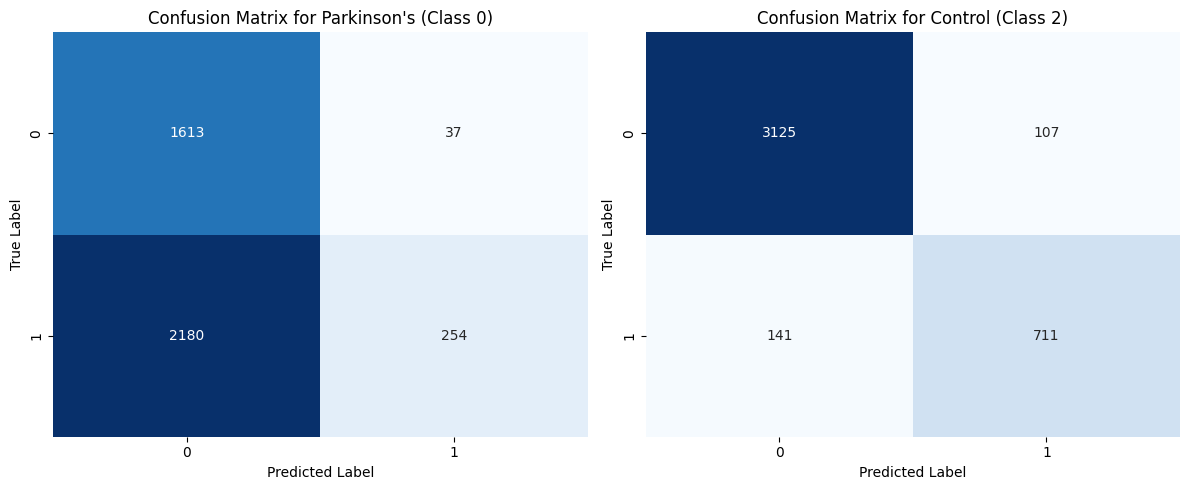

In [ ]:
from sklearn.metrics import precision_score, f1_score, confusion_matrix

# Flatten the true labels and predicted labels for the selected classes
y_test_selected = y_test_bin[:, 0]  # Parkinson's (class 0)
y_pred_selected = (y_pred_binary[:, 0] == 1)  # Predicted as Parkinson's (class 0)
y_test_control = y_test_bin[:, 2]  # Control (class 2)
y_pred_control = (y_pred_binary[:, 2] == 1)  # Predicted as Control (class 2)

# Calculate precision score for Parkinson's vs. Control
precision_parkinson = precision_score(y_test_selected, y_pred_selected)
precision_control = precision_score(y_test_control, y_pred_control)

# Calculate F1 score for Parkinson's vs. Control
f1_parkinson = f1_score(y_test_selected, y_pred_selected)
f1_control = f1_score(y_test_control, y_pred_control)

# Print precision and F1 score
print("Precision for Parkinson's:", precision_parkinson)
print("Precision for Control:", precision_control)
print("F1 Score for Parkinson's:", f1_parkinson)
print("F1 Score for Control:", f1_control)

# Compute confusion matrix for Parkinson's vs. Control
conf_matrix_parkinson = confusion_matrix(y_test_selected, y_pred_selected)
conf_matrix_control = confusion_matrix(y_test_control, y_pred_control)

# Plot confusion matrix for Parkinson's vs. Control
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_parkinson, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix for Parkinson's (Class 0)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_control, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix for Control (Class 2)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.tight_layout()
plt.show()


128/128 [==============================] - 19s 148ms/step


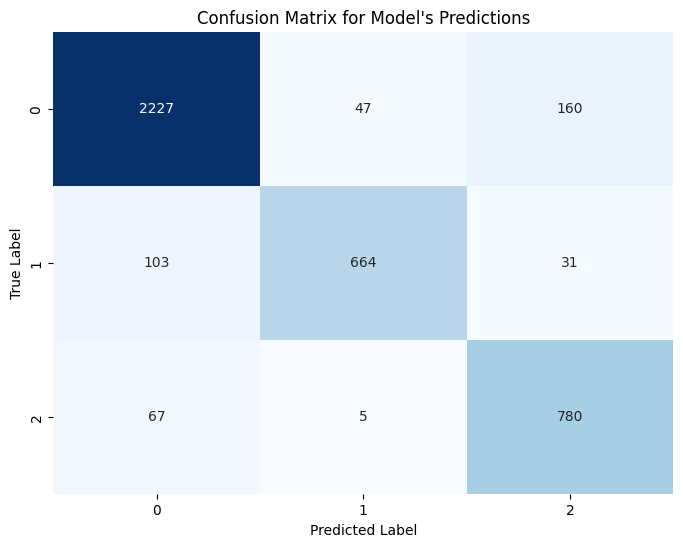

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Make predictions
y_pred = model.predict(X_test)

# Binarize the labels
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Get the class predictions for the entire test set
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_onehot, axis=1)

# Compute confusion matrix
conf_matrix_model = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix for the model's predictions
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_model, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix for Model's Predictions")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


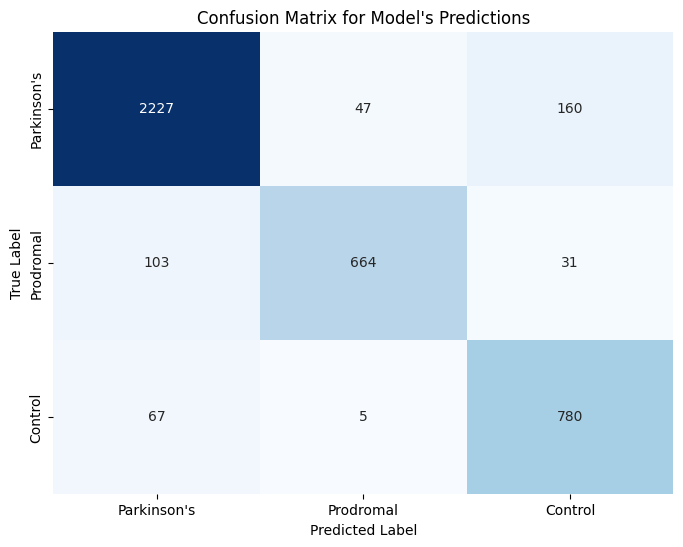

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming 'model' and 'X_test' are predefined and properly set up
#y_pred = model.predict(X_test)

# If 'y_test' contains direct class labels, use it directly
y_true_classes = y_test  # Use directly if y_test is already class labels

# Get the class predictions for the entire test set
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute confusion matrix
conf_matrix_model = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix for the model's predictions
plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_matrix_model, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix for Model's Predictions")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.set_xticklabels(['Parkinson\'s', 'Prodromal', 'Control'])
ax.set_yticklabels(['Parkinson\'s', 'Prodromal', 'Control'])
plt.show()


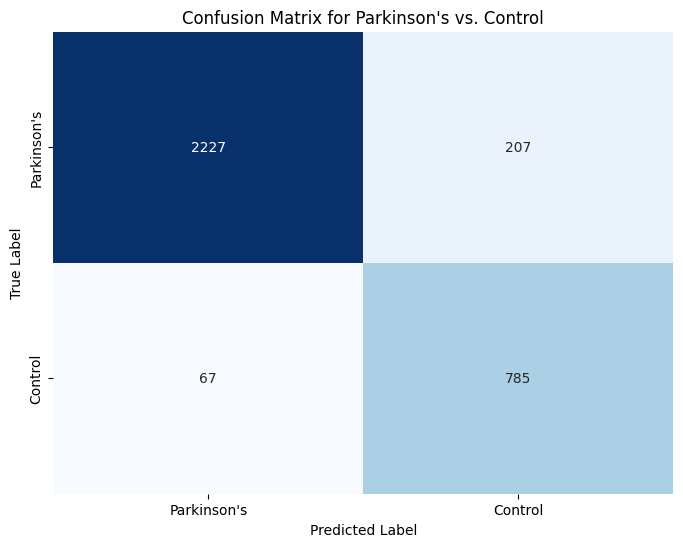

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming 'model' and 'X_test' are predefined and properly set up
# y_pred = model.predict(X_test)

# Filter instances where y_test is either 0 (Parkinson's) or 2 (Control)
indices = (y_test == 0) | (y_test == 2)
y_test_filtered = y_test[indices]
y_pred_filtered = y_pred[indices]

# Map Control label from 2 to 1 for binary classification
y_test_filtered = np.where(y_test_filtered == 2, 1, y_test_filtered)
y_pred_filtered_classes = np.argmax(y_pred_filtered, axis=1)
y_pred_filtered_classes = np.where(y_pred_filtered_classes == 2, 1, y_pred_filtered_classes)

# Compute confusion matrix
conf_matrix_model = confusion_matrix(y_test_filtered, y_pred_filtered_classes)

# Plot confusion matrix for the model's predictions
plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_matrix_model, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix for Parkinson's vs. Control")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.set_xticklabels(['Parkinson\'s', 'Control'])
ax.set_yticklabels(['Parkinson\'s', 'Control'])
plt.show()


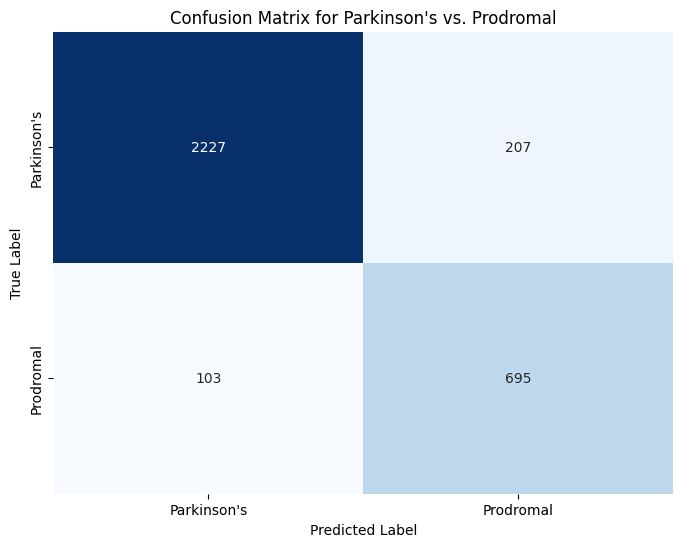

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming 'model' and 'X_test' are predefined and properly set up
# y_pred = model.predict(X_test)

# Filter instances where y_test is either 0 (Parkinson's) or 2 (Control)
indices = (y_test == 0) | (y_test == 1)
y_test_filtered = y_test[indices]
y_pred_filtered = y_pred[indices]

# Map Control label from 2 to 1 for binary classification
y_test_filtered = np.where(y_test_filtered == 2, 1, y_test_filtered)
y_pred_filtered_classes = np.argmax(y_pred_filtered, axis=1)
y_pred_filtered_classes = np.where(y_pred_filtered_classes == 2, 1, y_pred_filtered_classes)

# Compute confusion matrix
conf_matrix_model = confusion_matrix(y_test_filtered, y_pred_filtered_classes)

# Plot confusion matrix for the model's predictions
plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_matrix_model, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix for Parkinson's vs. Prodromal")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.set_xticklabels(['Parkinson\'s', 'Prodromal'])
ax.set_yticklabels(['Parkinson\'s', 'Prodromal'])
plt.show()

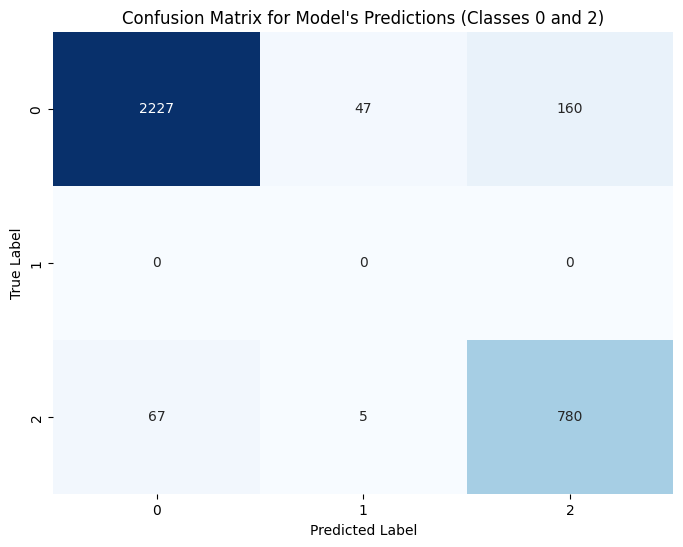

In [ ]:
# Filter the predictions and true labels for classes 0 and 2
y_pred_classes_02 = y_pred_classes[np.logical_or(y_true_classes == 0, y_true_classes == 2)]
y_true_classes_02 = y_true_classes[np.logical_or(y_true_classes == 0, y_true_classes == 2)]

# Compute confusion matrix for classes 0 and 2
conf_matrix_model_02 = confusion_matrix(y_true_classes_02, y_pred_classes_02)

# Plot confusion matrix for classes 0 and 2
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_model_02, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix for Model's Predictions (Classes 0 and 2)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


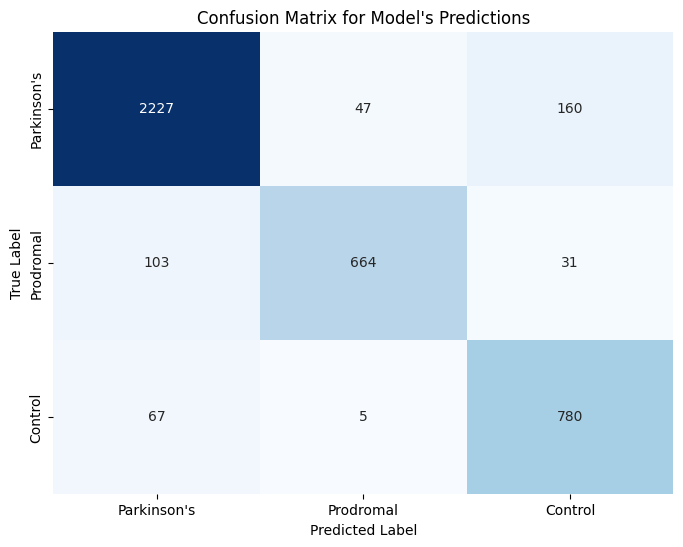

              precision    recall  f1-score   support

 Parkinson's       0.93      0.91      0.92      2434
   Prodromal       0.93      0.83      0.88       798
     Control       0.80      0.92      0.86       852

    accuracy                           0.90      4084
   macro avg       0.89      0.89      0.88      4084
weighted avg       0.90      0.90      0.90      4084



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Assuming 'model' and 'X_test' are predefined and properly set up
# y_pred = model.predict(X_test)

# If 'y_test' contains direct class labels, use it directly
y_true_classes = y_test  # Use directly if y_test is already class labels

# Get the class predictions for the entire test set
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute confusion matrix
conf_matrix_model = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix for the model's predictions
plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_matrix_model, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix for Model's Predictions")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.set_xticklabels(['Parkinson\'s', 'Prodromal', 'Control'])
ax.set_yticklabels(['Parkinson\'s', 'Prodromal', 'Control'])
plt.show()

# Print classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=['Parkinson\'s', 'Prodromal', 'Control'])
print(report)


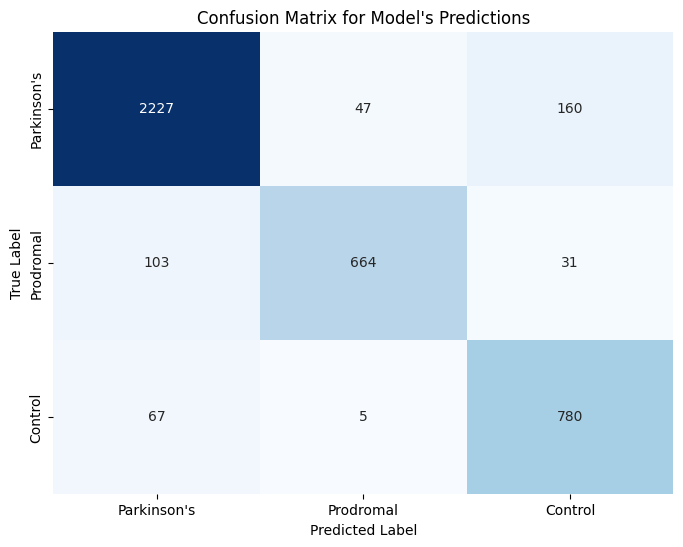

Parkinson's:
  Recall/Sensitivity: 0.91
  Specificity: 0.90
Prodromal:
  Recall/Sensitivity: 0.83
  Specificity: 0.98
Control:
  Recall/Sensitivity: 0.92
  Specificity: 0.94


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming 'model' and 'X_test' are predefined and properly set up
# y_pred = model.predict(X_test)

# If 'y_test' contains direct class labels, use it directly
y_true_classes = y_test  # Use directly if y_test is already class labels

# Get the class predictions for the entire test set
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute confusion matrix
conf_matrix_model = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix for the model's predictions
plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_matrix_model, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix for Model's Predictions")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.set_xticklabels(['Parkinson\'s', 'Prodromal', 'Control'])
ax.set_yticklabels(['Parkinson\'s', 'Prodromal', 'Control'])
plt.show()

# Calculate Recall, Sensitivity, and Specificity
class_labels = ['Parkinson\'s', 'Prodromal', 'Control']
metrics = {}

for i, label in enumerate(class_labels):
    TP = conf_matrix_model[i, i]
    FP = conf_matrix_model[:, i].sum() - TP
    FN = conf_matrix_model[i, :].sum() - TP
    TN = conf_matrix_model.sum() - (TP + FP + FN)

    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0

    metrics[label] = {'Recall/Sensitivity': recall, 'Specificity': specificity}

# Print the calculated metrics
for label, scores in metrics.items():
    print(f"{label}:")
    for metric, value in scores.items():
        print(f"  {metric}: {value:.2f}")
